In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from tpot import TPOTClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

import utils

# Read data and split it into train/test

In [2]:
def read_data_and_split(groups_considered):
    '''
    Read the data and splits it into train and test set. If groups_considered is set to False,
    we split randomly, without considering which user a row of data is from - which will produce
    misleading results, see interpretation at the bottom of this notebook.
    '''
    
    df = pd.read_parquet('data-input/flirt-nurse-acc-bvp-eda-hr-temp-60-10.parquet')

    # remove columns (see EDA)
    columns_to_drop = ['acc_y_entropy',
     'bvp_BVP_entropy',
     'acc_z_entropy',
     'hr_HR_n_sign_changes',
     'hr_l2_n_sign_changes',
     'temp_l2_n_sign_changes',
     'acc_l2_n_sign_changes',
     'acc_x_entropy',
     'temp_TEMP_n_sign_changes']

    df = df.drop(columns=columns_to_drop)

    display(df['label'].value_counts())

    # we need to favor the minority class, in this case: no stress
    df['label'] = df['label'].replace({0:1, 1:0})

    df.head(3)
    
    # split into train and test
    df_train, df_test = utils.create_train_test(df, 5, 'subject', 'label')

    X_train, y_train, groups_train = utils.split_df(df_train, 'subject', 'label')
    X_test, y_test, groups_test = utils.split_df(df_test, 'subject', 'label')


    # overwrite values without considereing groups if parameter is False
    if not groups_considered:
        # split into train and test
        print('You are not considering groups - this will produce misleading results!')
        df_train, df_test = utils.create_train_test_nogrp(df, 5, 'subject', 'label')

        X_train, y_train = utils.split_df_nogrp(df_train, 'subject', 'label')
        X_test, y_test = utils.split_df_nogrp(df_test, 'subject', 'label')


    # remove correlated features from train
    X_train, selected_features = utils.remove_correlated_features(X_train, 0.8)

    # remove the same columns from test
    X_test = X_test[selected_features]


    # show statistics
    display(X_train.shape)

    display(X_train.columns)

    # Check train and test set sizes
    print('Percentage train set:', len(y_train)/(len(y_train)+len(y_test)))
    print('Percentage test set:', len(y_test)/(len(y_train)+len(y_test)))

    print('\nClass distribution in train set: \n', y_train['label'].value_counts(normalize=True), '\n')

    print('Class distribution in test set: \n', y_test['label'].value_counts(normalize=True), '\n')


    # return
    return X_train, y_train, groups_train, X_test, y_test, groups_test

# TPOT - considering groups

In [3]:
X_train, y_train, groups_train, X_test, y_test, groups_test = read_data_and_split(True)

1    22370
0     4284
Name: label, dtype: int64

(21089, 81)

Index(['bvp_BVP_mean', 'bvp_BVP_std', 'bvp_BVP_skewness', 'bvp_BVP_kurtosis',
       'bvp_BVP_peaks', 'bvp_BVP_n_above_mean', 'bvp_BVP_n_below_mean',
       'bvp_BVP_perm_entropy', 'bvp_BVP_svd_entropy', 'bvp_l2_min',
       'bvp_l2_n_above_mean', 'bvp_l2_n_below_mean', 'bvp_l2_n_sign_changes',
       'bvp_l2_perm_entropy', 'acc_x_mean', 'acc_x_std', 'acc_x_min',
       'acc_x_max', 'acc_x_energy', 'acc_x_skewness', 'acc_x_kurtosis',
       'acc_x_peaks', 'acc_x_lineintegral', 'acc_x_n_above_mean',
       'acc_x_n_sign_changes', 'acc_x_perm_entropy', 'acc_y_mean', 'acc_y_std',
       'acc_y_min', 'acc_y_max', 'acc_y_energy', 'acc_y_skewness',
       'acc_y_kurtosis', 'acc_y_peaks', 'acc_y_n_above_mean',
       'acc_y_n_sign_changes', 'acc_y_svd_entropy', 'acc_z_mean', 'acc_z_std',
       'acc_z_min', 'acc_z_max', 'acc_z_energy', 'acc_z_skewness',
       'acc_z_kurtosis', 'acc_z_peaks', 'acc_z_n_above_mean',
       'acc_z_n_sign_changes', 'acc_z_pct_95', 'acc_l2_mean',
       'acc_l2_sk

Percentage train set: 0.7912133263300067
Percentage test set: 0.20878667366999323

Class distribution in train set: 
 0    0.845133
1    0.154867
Name: label, dtype: float64 

Class distribution in test set: 
 0    0.817071
1    0.182929
Name: label, dtype: float64 



In [4]:
tpot = TPOTClassifier(generations=1,
                      population_size=5,
                      scoring='f1',
                      cv=2,
                      n_jobs=-1,
                      verbosity=3,
                      random_state=0)

In [5]:
%%time
tpot.fit(X_train, y_train.values.ravel(), groups=groups_train.values.ravel())

32 operators have been imported by TPOT.


C:\Tools\anaconda3\envs\stress01\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Optimization Progress:   0%|          | 0/10 [00:00<?, ?pipeline/s]

Skipped pipeline #10 due to time out. Continuing to the next pipeline.

Generation 1 - Current Pareto front scores:

-1	0.3697629482121799	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.4, XGBClassifier__verbosity=0)
CPU times: total: 1.61 s
Wall time: 6min 27s


TPOTClassifier(cv=2, generations=1, n_jobs=-1, population_size=5,
               random_state=0, scoring='f1', verbosity=3)

In [6]:
print(f"TPOT score (F1) on test data: {tpot.score(X_test, y_test.values.ravel()):.2f}")

TPOT score (F1) on test data: 0.00


In [7]:
y_test_predict = tpot.predict(X_test)
y_test_predict_proba = tpot.predict_proba(X_test)[:,1]

In [8]:
print('accuracy: '+str(accuracy_score(y_test, y_test_predict)))
print('precision: '+str(precision_score(y_test, y_test_predict)))
print('recall: '+str(recall_score(y_test, y_test_predict)))
print('f1_score: '+str(f1_score(y_test, y_test_predict)))
print('roc_auc: '+str(roc_auc_score(y_test, y_test_predict)))
print('Class distribution in test set: \n', y_test['label'].value_counts(normalize=True), '\n')
print('average_precision: '+str(average_precision_score(y_test, y_test_predict_proba)))

accuracy: 0.8138364779874214
precision: 0.0
recall: 0.0
f1_score: 0.0
roc_auc: 0.4980206729711898
Class distribution in test set: 
 0    0.817071
1    0.182929
Name: label, dtype: float64 

average_precision: 0.17932449497728947


In [9]:
confusion_matrix(y_test, y_test_predict)

array([[4529,   18],
       [1018,    0]], dtype=int64)

The baseline to beat is the percentage of positive cases: 0.1829290206648697


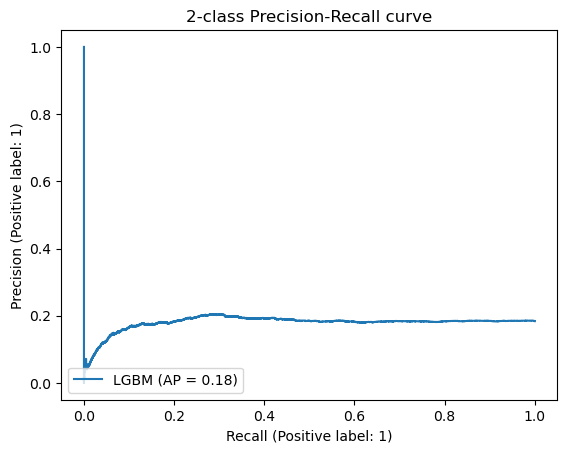

In [10]:
prd = PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_proba, name='Model')
_ = prd.ax_.set_title('2-class Precision-Recall curve')
print('The baseline to beat is the percentage of positive cases:', y_test['label'].value_counts(normalize=True)[1])

# TPOT - NOT considering groups

In [11]:
X_train, y_train, groups_train, X_test, y_test, groups_test = read_data_and_split(False)

1    22370
0     4284
Name: label, dtype: int64

You are not considering groups - this will produce misleading results!


(21323, 82)

Index(['bvp_BVP_mean', 'bvp_BVP_std', 'bvp_BVP_skewness', 'bvp_BVP_kurtosis',
       'bvp_BVP_peaks', 'bvp_BVP_n_above_mean', 'bvp_BVP_n_below_mean',
       'bvp_BVP_perm_entropy', 'bvp_BVP_svd_entropy', 'bvp_l2_min',
       'bvp_l2_n_above_mean', 'bvp_l2_n_below_mean', 'bvp_l2_n_sign_changes',
       'bvp_l2_perm_entropy', 'acc_x_mean', 'acc_x_std', 'acc_x_min',
       'acc_x_max', 'acc_x_energy', 'acc_x_skewness', 'acc_x_kurtosis',
       'acc_x_peaks', 'acc_x_lineintegral', 'acc_x_n_above_mean',
       'acc_x_n_sign_changes', 'acc_x_perm_entropy', 'acc_y_mean', 'acc_y_std',
       'acc_y_min', 'acc_y_max', 'acc_y_energy', 'acc_y_skewness',
       'acc_y_kurtosis', 'acc_y_peaks', 'acc_y_n_above_mean',
       'acc_y_n_sign_changes', 'acc_y_pct_95', 'acc_y_svd_entropy',
       'acc_z_mean', 'acc_z_std', 'acc_z_min', 'acc_z_max', 'acc_z_energy',
       'acc_z_skewness', 'acc_z_kurtosis', 'acc_z_n_above_mean',
       'acc_z_n_sign_changes', 'acc_z_pct_95', 'acc_l2_mean',
       'acc_l2_s

Percentage train set: 0.799992496435807
Percentage test set: 0.200007503564193

Class distribution in train set: 
 0    0.838859
1    0.161141
Name: label, dtype: float64 

Class distribution in test set: 
 0    0.84093
1    0.15907
Name: label, dtype: float64 



In [12]:
tpot = TPOTClassifier(generations=1,
                      population_size=5,
                      scoring='f1',
                      cv=2,
                      n_jobs=-1,
                      verbosity=3,
                      random_state=0)

In [13]:
%%time
tpot.fit(X_train, y_train.values.ravel())

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/10 [00:00<?, ?pipeline/s]

Skipped pipeline #10 due to time out. Continuing to the next pipeline.

Generation 1 - Current Pareto front scores:

-1	0.5738901167969361	XGBClassifier(input_matrix, XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.4, XGBClassifier__verbosity=0)

-2	0.88502565170968	XGBClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=False, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.5, RandomForestClassifier__min_samples_leaf=18, RandomForestClassifier__min_samples_split=11, RandomForestClassifier__n_estimators=100), XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=2, XGBClassifier__min_child_weight=7, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.4, XGBClassifier__verbosity=0)
CPU times: total: 24 s
Wall time: 8min 4s


TPOTClassifier(cv=2, generations=1, n_jobs=-1, population_size=5,
               random_state=0, scoring='f1', verbosity=3)

In [14]:
print(f"TPOT score (F1) on test data: {tpot.score(X_test, y_test.values.ravel()):.2f}")

TPOT score (F1) on test data: 0.94


C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [15]:
y_test_predict = tpot.predict(X_test)
y_test_predict_proba = tpot.predict_proba(X_test)[:,1]

C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Tools\anaconda3\envs\stress01\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [16]:
print('accuracy: '+str(accuracy_score(y_test, y_test_predict)))
print('precision: '+str(precision_score(y_test, y_test_predict)))
print('recall: '+str(recall_score(y_test, y_test_predict)))
print('f1_score: '+str(f1_score(y_test, y_test_predict)))
print('roc_auc: '+str(roc_auc_score(y_test, y_test_predict)))
print('Class distribution in test set: \n', y_test['label'].value_counts(normalize=True), '\n')
print('average_precision: '+str(average_precision_score(y_test, y_test_predict_proba)))

accuracy: 0.9825548677546426
precision: 0.9553679131483716
recall: 0.9339622641509434
f1_score: 0.9445438282647586
roc_auc: 0.9628544312055186
Class distribution in test set: 
 0    0.84093
1    0.15907
Name: label, dtype: float64 

average_precision: 0.9818740335619265


The baseline to beat is the percentage of positive cases: 0.15906959294691428


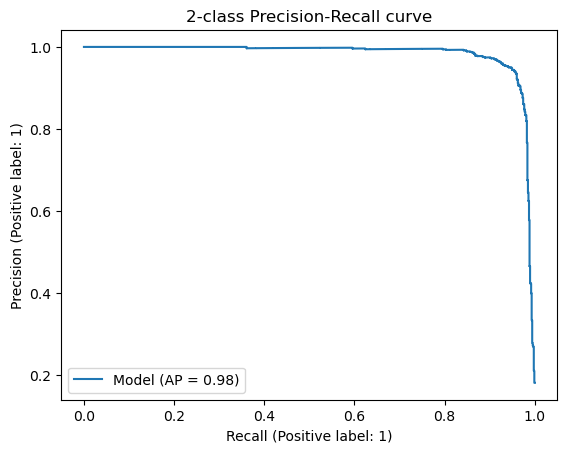

In [18]:
prd = PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_proba, name='Model')
_ = prd.ax_.set_title('2-class Precision-Recall curve')
print('The baseline to beat is the percentage of positive cases:', y_test['label'].value_counts(normalize=True)[1])

# Interpretation

I created a TPOT baseline model in this notebook.

The data used was created with ```FLIRT``` with a ```window_size``` of ```60``` and a step size of ```10```.

The data of each user is either in the train or in the test set. Internally, TPOT does a cross-validation with the training data, and again only uses the data of each user in either training or validation set. The results show that a prediction of a stress state does not seem possible at all and that the model is as good as random guessing. We can see this in the precision-recall-curve and the confusion matrix.

As a means of comparison, I created a TPOT-pipeline that does NOT take care of putting one user in either train or test set. Now the model shows a good performance. But this is misleading: Using data from the same user in both train and test set does not evaluate how the model performs for new, unseen users. Furthermore, with a steps size of 10 and a windows size of 60, there will be a large overap between calculated features. If they end up in both train and test set, the perfomance is better because during training we saw almost identical data from almost identical situations. Such a model will not help in predicting stress on new users. The reason for the bad performance is likely the way the data was collected and labeled: In the paper about the dataset, it sounds like the labeling was done retroactively and for rather coarse time windows.

Conclusion:
We will proceed only with the WESAD dataset.